#  Plot CellphoneDB

In [133]:
library(dplyr)
library(reshape2)
library(plyr)
library(RColorBrewer)
library(ggplot2)
library(pheatmap)
library(cowplot)

get_cells2genes = function(genes2filter = NULL){
    # Merge as data frame for plotting with ggplot
    cells2genesCP = subset(PERC, Gene %in% genes2plot)
    # transfer expression info     
    cells2genesCP$cell = cells2genesCP$L1
    cells2genesCP$gene = cells2genesCP$Gene
    cells2genesCP$id = paste(cells2genesCP$cell, cells2genesCP$gene)
    cells2genesCP$isDE = cells2genesCP$id %in% DEGs$id
    return(cells2genesCP)
}

In [134]:
  genes2filter = genes2plot
# Merge as data frame for plotting with ggplot
    cells2genesCP = subset(PERC, Gene %in% genes2plot)
cells2genesCP
#     # transfer expression info     
#     cells2genesCP$cell = cells2genesCP$L1
#     cells2genesCP$gene = cells2genesCP$Gene
#     cells2genesCP$id = paste(cells2genesCP$cell, cells2genesCP$gene)
#     cells2genesCP$isDE = cells2genesCP$id %in% DEGs$id
head(PERC)

,X,Gene,P.Value,adj.P.Val,logFC,mean_cluster,mean_rest,log2_FC,percent_cluster,percent_rest,L1,id
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
22481,98,CCR1,2.204701e-83,7.074781e-81,NA,1.7217077,0.02123930,6.340961,41.620879,0.5241142,myeloid_scanpy,CCR1
23785,1497,CCR7,6.182847e-06,5.838701e-05,NA,0.1774342,0.03276079,2.437242,4.258242,0.5919019,myeloid_scanpy,CCR7
28109,357,CCR1,3.306496e-37,1.318450e-35,NA,0.6210411,0.02893669,4.423717,13.667954,0.7393684,NK_scanpy,CCR1
29336,1736,CCR7,8.061084e-04,3.540740e-03,NA,0.1663895,0.03163043,2.395179,2.084942,0.6041792,NK_scanpy,CCR7
55756,132,CCR7,1.607480e-52,3.148978e-50,NA,1.2848598,0.01316569,6.608684,20.955166,0.2891086,T_cell_scanpy,CCR7
57239,1879,CCR1,1.312486e-02,5.761193e-02,NA,0.1147086,0.04021481,1.512175,2.339181,0.9902800,T_cell_scanpy,CCR1


,X,Gene,P.Value,adj.P.Val,logFC,mean_cluster,mean_rest,log2_FC,percent_cluster,percent_rest,L1,id
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0,CLEC14A,0,0,NA,3.898061,0.5887859,2.726942,93.34471,12.60960,endo_arterial_scanpy,CLEC14A
2,1,PECAM1,0,0,NA,3.829790,0.6370335,2.587824,91.74061,13.41775,endo_arterial_scanpy,PECAM1
3,2,CLDN5,0,0,NA,4.021709,0.7648119,2.394632,93.13993,15.30688,endo_arterial_scanpy,CLDN5
4,3,EMCN,0,0,NA,3.599415,0.5367041,2.745564,88.12287,11.55780,endo_arterial_scanpy,EMCN
5,4,RNASE1,0,0,NA,3.872670,0.7791134,2.313423,92.73038,15.97605,endo_arterial_scanpy,RNASE1
6,5,EGFL7,0,0,NA,3.906046,0.8213232,2.249687,93.61775,17.69359,endo_arterial_scanpy,EGFL7


# Load Cellphone Genes

In [135]:
# Define variables
filter_int_user_curated = T #Use only user_curated interactions?
per_cutoff = 0.1 # min % of cells in the cluster required  with expression > 0 for the gene
pval_cutoff = 0.001 # max adjusted p-value requeired to consider a gene as DEG
logFC_cutoff = 0 # min logFC to consider a gene as DEG

In [136]:
# Load cellphone database - genes and complexes file
# Gene names
genes_cpDB = read.delim('~/cellphoneDB/hsa_uniprot.txt', stringsAsFactors = F, sep = '\t')

# Complexes members
com_cpDB = read.csv('~/farm/CellPhoneDB-data_smallmolecules/data/sources/complex_curated.csv', stringsAsFactors = F)
com_cpDB = unique(com_cpDB)
com_cpDB$complex_name = paste0('complex:', com_cpDB$complex_name)
# Generate complexes2gene symbol dictionary
Com2Gene = lapply(com_cpDB$complex_name, function(cx) subset(genes_cpDB, uniprot %in% unlist(com_cpDB[com_cpDB$complex_name == cx, 2:5]) )$gene_name )
Com2Gene = lapply(Com2Gene, unique)
names(Com2Gene) = com_cpDB$complex_name
                  
# Load interactions from cellphoneDB/out/means.txt output file                   
int_cpDB = read.delim('data/cellphoneDB/out/means.txt', stringsAsFactors = F)[, 1:10]
# MANDATORY: remove "curated" because we have cleaned and renamed them (this is a long story, just do it)
int_cpDB = subset(int_cpDB, annotation_strategy != 'curated')
# OPTIONAL: Use only user_curated interactions?
if(filter_int_user_curated)
    int_cpDB = subset(int_cpDB, annotation_strategy == 'user_curated')
# Generate Int2Gene dictionary
Int2Gene = apply(int_cpDB, 1, function(int) {
    int = unname(int)
    if(int[5] == '') # if partnerA is complex, then retrieve members from dictionary
       partnerA = Com2Gene[[int[3]]]
    else  # if partnerA is a single gene, take name from file
       partnerA = int[5]
    if(int[6] == '')  # if partnerB is complex, then retrieve members from dictionary
       partnerB = Com2Gene[[int[4]]]
    else  # if partnerB is a single gene, take name from file
       partnerB = int[6]
    list(partner_a=partnerA,partner_b=partnerB)
    }) 
names(Int2Gene) = int_cpDB$interacting_pair

# Load expression information

### % Expr

In [137]:
# Load percentage expression info
# you need to put in a folder a file for each cluster that you included in cellphone
# The file must contain at least three columns (aka, you can reuse the output of the DEG files):
# - Gene: gene symbol
# - cluster: cell type
# - percentExpr_cluster: % of cells in the cluster with expression > 0 for the gene
path_Exp = '/home/jovyan/farm/endometrium/data/cellphoneDB/clusterDEGs_and_TFs/DEGs/'


# Load
Per_files = list.files(path_Exp, pattern = '_DEGs.csv', full.names = T) %>% grep('scanpy', ., value = T, invert = T)  %>% grep('vs', ., value = T, invert = T)
Per_names = list.files(path_Exp, pattern = '_DEGs.csv') %>% grep('scanpy', ., value = T, invert = T) %>% grep('vs', ., value = T, invert = T)
Per_df = lapply(Per_files, read.csv, stringsAsFactors = F) 

# Set rownames as genes, for convenience
Per_df = lapply(Per_df, function(x){ 
    rownames(x) = x$Gene
    return(x) })

# Remove genes not in cellphone or not expressed
Per_df = lapply(Per_df, function(x) subset(x, Gene %in% genes_cpDB$gene_name & percentExpr_cluster > per_cutoff ))
                
# Build dictionary clusters2expressed genes                       
names(Per_df) = gsub('_DEGs.csv', '', Per_names)
                                              
PERC = melt(Per_df, id.vars = names(Per_df[[1]]))
PERC$id = paste(PERC$cluster, PERC$Gene)                      
head(PERC)
                      

,cluster,Gene,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest,L1,id
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,epithelial_ciliated,C20orf85,2.840697,0,0,2.852913,0.012215,0.981308,0.016866,epithelial_ciliated,epithelial_ciliated C20orf85
2,epithelial_ciliated,FAM183A,2.443881,0,0,2.455799,0.011918,0.990654,0.016683,epithelial_ciliated,epithelial_ciliated FAM183A
3,epithelial_ciliated,C1orf194,2.623840,0,0,2.636490,0.012650,0.990654,0.019677,epithelial_ciliated,epithelial_ciliated C1orf194
4,epithelial_ciliated,RSPH1,2.434440,0,0,2.457764,0.023324,0.992991,0.045527,epithelial_ciliated,epithelial_ciliated RSPH1
5,epithelial_ciliated,CAPSL,1.862578,0,0,1.868084,0.005506,0.971963,0.008678,epithelial_ciliated,epithelial_ciliated CAPSL
6,epithelial_ciliated,C11orf88,2.034483,0,0,2.040417,0.005934,0.962617,0.008494,epithelial_ciliated,epithelial_ciliated C11orf88


### DEGs

In [138]:
# load DE expression info
# you need to put in a folder the DE files of the clusters that you're interested in
# The file must contain at least four columns (aka, you can reuse the output of the DEG files):
# - Gene: gene symbol
# - cluster: cell type
# - adj.P.Val: adjusted p-value from the DE test
# - logFC: from the DE test
path_DE = '/home/jovyan/farm/endometrium/data/cellphoneDB/clusterDEGs_and_TFs/DEGs_withinEpithelial/'

# Load
DE_files = list.files(path_DE, pattern = 'DEGs.csv', full.names = T)
DE_df = lapply(DE_files, read.csv, stringsAsFactors = F)

# Set rownames as genes, for convenience
DE_df = lapply(DE_df, function(x){ 
    rownames(x) = x$Gene
    return(x) })

# Remove genes not in cellphone
DE_df = lapply(DE_df, function(x) subset(x, Gene %in% genes_cpDB$gene_name )) 

# Build dictionary clusters2DEGs              
names(DE_df) = sapply(DE_df, function(x) x$cluster[1])
is_DE = lapply(DE_df, function(x) subset(x, adj.P.Val < pval_cutoff & logFC > logFC_cutoff)$Gene )
               
length(DE_df)
names(DE_df)
               
               
DEGs = melt(DE_df, id.vars = names(DE_df[[1]]))
DEGs$id = paste(DEGs$cluster, DEGs$Gene)                      
head(DEGs)    

[1] 7

[1] "epithelial_ciliated"      "epithelial_glandular"    
[3] "epithelial_LGR5"          "epithelial_LYPD1"        
[5] "epithelial_proliferative" "epithelial_WIF1_1"       
[7] "epithelial_WIF1_2"

,cluster,Gene,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest,L1,id
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,epithelial_ciliated,C20orf85,2.844464,0,0,2.853057,0.008594,0.981308,0.013348,epithelial_ciliated,epithelial_ciliated C20orf85
2,epithelial_ciliated,TPPP3,3.636630,0,0,3.687252,0.050622,0.997664,0.070241,epithelial_ciliated,epithelial_ciliated TPPP3
3,epithelial_ciliated,FAM183A,2.447016,0,0,2.455940,0.008924,0.990654,0.014004,epithelial_ciliated,epithelial_ciliated FAM183A
4,epithelial_ciliated,C1orf194,2.620543,0,0,2.636632,0.016089,0.990654,0.029322,epithelial_ciliated,epithelial_ciliated C1orf194
5,epithelial_ciliated,PIFO,2.217015,0,0,2.246613,0.029598,0.988318,0.068709,epithelial_ciliated,epithelial_ciliated PIFO
6,epithelial_ciliated,RSPH1,2.407092,0,0,2.457906,0.050814,0.992991,0.116849,epithelial_ciliated,epithelial_ciliated RSPH1


# Epithelial crosstalk

## Receptors

receptors; FZD1-10; LRP5; LRP6; LRG4; LRG5; KREMEN; NOTCH1-4



#### Load genes of interest

In [139]:
genes2plot = c(read.csv('data/cellphoneDB/genes2plot/dotplot1.txt', stringsAsFactors = F, sep = '\t', header = F)$V1,
               read.csv('data/cellphoneDB/genes2plot/dotplot3.txt', stringsAsFactors = F, sep = '\t', header = F)$V1)
genes2plot

[1] "LRP5"    "LRP6"    "LGR4"    "LGR5"    "LGR6"    "FZD1"    "FZD2"   
 [8] "FZD3"    "FZD4"    "FZD5"    "FZD6"    "FZD7"    "FZD8"    "FZD9"   
[15] "FZD10"   "KREMEN1" "KREMEN2" "NOTCH1"  "NOTCH2"  "NOTCH3"  "NOTCH4"

#### Generate cells2genes in cellphone for interactions containing genes of interest

In [140]:
cells2genes = get_cells2genes(genes2filter = genes2plot)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)
 

,cluster,Gene,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest,L1,id,cell,gene,isDE
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>
1064,epithelial_ciliated,FZD6,0.22280832,1.420727e-74,2.517269e-73,0.294918,0.072110,0.474299,0.111098,epithelial_ciliated,epithelial_ciliated FZD6,epithelial_ciliated,FZD6,TRUE
1822,epithelial_ciliated,LGR4,0.15985676,2.894223e-31,2.857318e-30,0.244317,0.084460,0.399533,0.118492,epithelial_ciliated,epithelial_ciliated LGR4,epithelial_ciliated,LGR4,TRUE
1841,epithelial_ciliated,LRP5,0.12192597,8.649658e-31,8.445868e-30,0.183498,0.061572,0.313084,0.106942,epithelial_ciliated,epithelial_ciliated LRP5,epithelial_ciliated,LRP5,TRUE
2743,epithelial_ciliated,FZD3,0.11341145,2.876376e-15,1.845956e-14,0.228460,0.115048,0.387850,0.171718,epithelial_ciliated,epithelial_ciliated FZD3,epithelial_ciliated,FZD3,TRUE
4750,epithelial_ciliated,LGR5,0.03348402,5.138395e-05,1.744113e-04,0.065743,0.032259,0.123832,0.050721,epithelial_ciliated,epithelial_ciliated LGR5,epithelial_ciliated,LGR5,TRUE
6737,epithelial_ciliated,KREMEN1,0.02280036,4.022680e-02,8.477093e-02,0.088736,0.065936,0.156542,0.099792,epithelial_ciliated,epithelial_ciliated KREMEN1,epithelial_ciliated,KREMEN1,TRUE


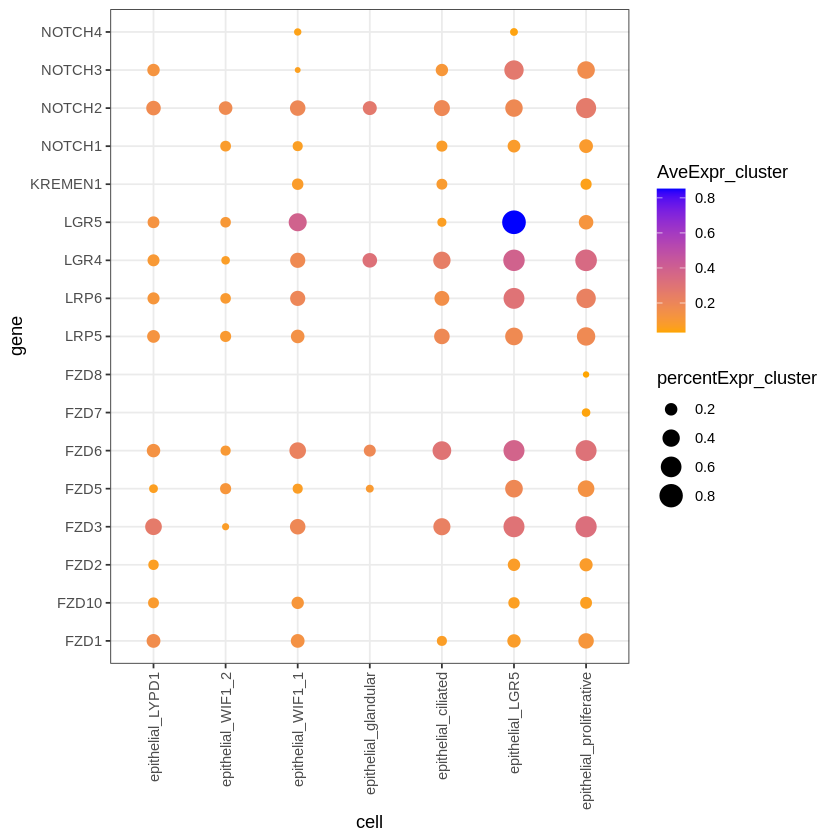

In [141]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# filter epi
df = df[ grep('epi', df$cell) ,]
# ordre FZD1-10; LRP5; LRP6; LRG4; LRG5; KREMEN; NOTCH1-4
df$gene = factor(df$gene, levels = c(grep('FZD', sort(unique(df$gene)), value = T),
                                     grep('LRP', sort(unique(df$gene)), value = T),
                                     grep('LGR', sort(unique(df$gene)), value = T),
                                     grep('KREMEN', sort(unique(df$gene)), value = T),
                                     grep('NOTCH', sort(unique(df$gene)), value = T) ))
# ordre LYPD1; WIF1_2; WIF1_1; Ciliated; Glandular: LGR5; proliferative
df$cell = factor(df$cell, levels = rev(c('epithelial_proliferative', 'epithelial_LGR5', 
                                     'epithelial_ciliated', 'epithelial_glandular', 'epithelial_WIF1_1', 'epithelial_WIF1_2', 
                                     'epithelial_LYPD1') ))
ggplot(df,  aes(y = gene,
                    x = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster), ) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

ggsave(filename = 'data/cellphoneDB/clusterDEGs_and_TFs/L_and_R_plots/dotplotReceptors.pdf', dpi = 300, width = 6, height = 6)

# Ligands

 ligands: WNTxxxx; RSPO1; RSPO3; DKK1; WIF1; SOSTDC1; DLL1; DLL3; DLL4; JAG1; JAG2



#### Load genes of interest

In [142]:
genes2plot = c(read.csv('data/cellphoneDB/genes2plot/dotplot2.txt', stringsAsFactors = F, sep = '\t', header = F)$V1,
               read.csv('data/cellphoneDB/genes2plot/dotplot4.txt', stringsAsFactors = F, sep = '\t', header = F)$V1)
genes2plot

[1] "WNT1"    "WNT2"    "WNT2B"   "WNT3"    "WNT3A"   "WNT4"    "WNT5A"  
 [8] "WNT5B"   "WNT6"    "WNT7A"   "WNT7B"   "WNT8A"   "WNT8B"   "WNT9A"  
[15] "WNT9B"   "WNT10A"  "WNT10B"  "WNT11"   "WNT16"   "DKK1"    "WIF1"   
[22] "SFRP"    "CER1"    "NDP"     "SOSTDC1" "RSPO1"   "RSPO2"   "RSPO3"  
[29] "RSPO4"   "DLL1"    "DLL3"    "DLL4"    "JAG1"    "JAG2"

#### Generate cells2genes in cellphone for interactions containing genes of interest

In [143]:
cells2genes = get_cells2genes(genes2filter = genes2plot)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)
 

,cluster,Gene,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest,L1,id,cell,gene,isDE
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>
489,epithelial_ciliated,JAG1,0.59083385,0.000000e+00,0.000000e+00,0.688484,0.097650,0.707944,0.133830,epithelial_ciliated,epithelial_ciliated JAG1,epithelial_ciliated,JAG1,TRUE
1233,epithelial_ciliated,JAG2,0.09498814,4.275001e-59,6.486311e-58,0.109197,0.014209,0.186916,0.023466,epithelial_ciliated,epithelial_ciliated JAG2,epithelial_ciliated,JAG2,TRUE
5013,epithelial_ciliated,WNT5A,-0.08292390,1.975906e-04,6.261065e-04,0.146081,0.229005,0.252336,0.255622,epithelial_ciliated,epithelial_ciliated WNT5A,epithelial_ciliated,WNT5A,TRUE
13333,epithelial_glandular,JAG1,0.05253771,6.980479e-12,2.227740e-11,0.159102,0.106564,0.142057,0.149312,epithelial_glandular,epithelial_glandular JAG1,epithelial_glandular,JAG1,TRUE
15405,epithelial_LGR5,WNT7A,0.86420784,0.000000e+00,0.000000e+00,0.874882,0.010674,0.742574,0.014439,epithelial_LGR5,epithelial_LGR5 WNT7A,epithelial_LGR5,WNT7A,TRUE
15919,epithelial_LGR5,JAG1,0.26475783,8.956678e-17,3.783646e-15,0.375874,0.111117,0.633663,0.145528,epithelial_LGR5,epithelial_LGR5 JAG1,epithelial_LGR5,JAG1,TRUE


In [144]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
unique(sort(df$gene))

[1] "DKK1"    "DLL1"    "JAG1"    "JAG2"    "NDP"     "RSPO1"   "RSPO3"  
 [8] "SOSTDC1" "WIF1"    "WNT11"   "WNT2"    "WNT2B"   "WNT4"    "WNT5A"  
[15] "WNT5B"   "WNT6"    "WNT7A"

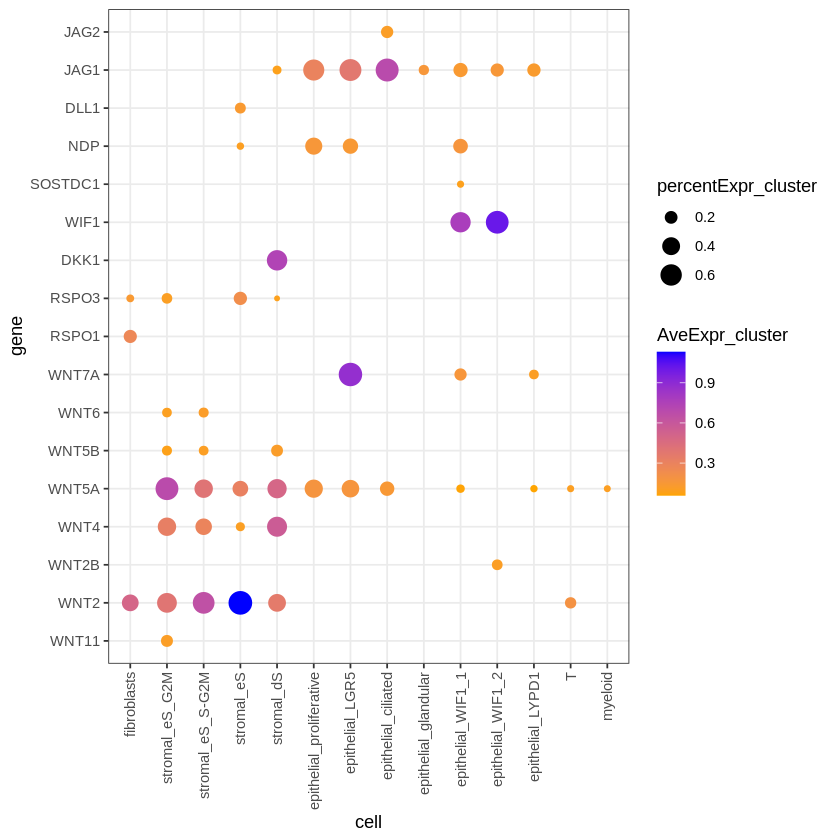

In [145]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# ordre WNTxxxx; RSPO1; RSPO3; DKK1; WIF1; SOSTDC1; DLL1; DLL3; DLL4; JAG1; JAG2
df$gene = factor(df$gene, levels = c(grep('WNT', sort(unique(df$gene)), value = T),
                                     grep('RSP', sort(unique(df$gene)), value = T),
                                     'DKK1', 'WIF1', 'SOSTDC1', 'NDP',
                                     grep('DLL', sort(unique(df$gene)), value = T),
                                     grep('JAG', sort(unique(df$gene)), value = T) ))
# ordre fibroblasts; eS_G2M;  eS_S_G2M; eS; dS; proliferative; LGR5; Glandular; Ciliated; WIF1_1; WIF1_2; LYPD1; T cell; Myeloid
df$cell = factor(df$cell, levels = c('fibroblasts', 
                                    'stromal_eS_G2M', 'stromal_eS_S-G2M', 'stromal_eS', 'stromal_dS', 
                                    'epithelial_proliferative', 'epithelial_LGR5', 
                                     'epithelial_ciliated', 'epithelial_glandular', 'epithelial_WIF1_1', 'epithelial_WIF1_2', 
                                     'epithelial_LYPD1',
                                    'T', 'myeloid', 'NK') )

ggplot(df,  aes(y = gene,
                    x = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
ggsave(filename = 'data/cellphoneDB/clusterDEGs_and_TFs/L_and_R_plots/dotplotLigands.pdf', dpi = 300, width = 6, height = 6)

# Immune/PV crosstalk 

Left Receptors: columns (endo_venular; endo_arterial; endo_lymphatic) & rows (CCL14; CCL1)

Right Ligands: columns (macrophages; NK cells; T cells) & rows (CCR1; CCR7)

## Ligands

 ligands: CCR1; CCR7



#### Load genes of interest

In [146]:
genes2plot = c('CCR1', 'CCR7')
genes2plot

[1] "CCR1" "CCR7"

#### Generate cells2genes in cellphone for interactions containing genes of interest

In [147]:
cells2genes = get_cells2genes(genes2filter = genes2plot)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)
 

,cluster,Gene,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest,L1,id,cell,gene,isDE
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>
65950,myeloid,CCR1,0.4412270,0.000000e+00,0.000000e+00,0.455337,0.014110,0.416209,0.014691,myeloid,myeloid CCR1,myeloid,CCR1,FALSE
72657,NK,CCR1,0.1178712,2.551474e-95,9.197148e-94,0.142020,0.024149,0.136680,0.023359,NK,NK CCR1,NK,CCR1,FALSE
106098,TRUE,CCR7,0.2982286,0.000000e+00,0.000000e+00,0.305003,0.006774,0.209552,0.005835,T,T CCR7,T,CCR7,FALSE


In [148]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
unique(sort(df$gene))

[1] "CCR1" "CCR7"

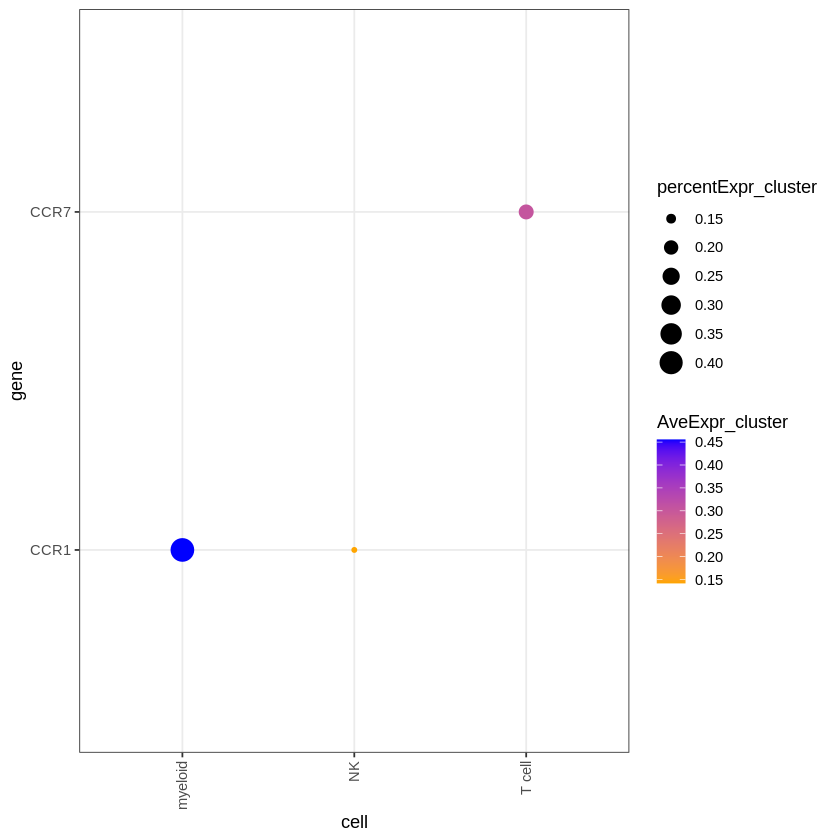

In [149]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# subset
df = subset(df, cell %in% c('T', 'myeloid', 'NK') )
df$cell[ df$cell == 'T'] = 'T cell'

ggplot(df,  aes(y = gene,
                    x = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
ggsave(filename = 'data/cellphoneDB/clusterDEGs_and_TFs/L_and_R_plots/Figure1F_dotplotLigands.pdf', dpi = 300, width = 4, height = 3.8)

## Receptors

receptors; CCL14, CCL1


#### Load genes of interest

### Load expr info

We reload this fo r endo as we did not include endo cells in cellphone analysis before because of the compartimentalization.


In [150]:
# Load percentage expression info
# you need to put in a folder a file for each cluster that you included in cellphone
# The file must contain at least three columns (aka, you can reuse the output of the DEG files):
# - Gene: gene symbol
# - cluster: cell type
# - percentExpr_cluster: % of cells in the cluster with expression > 0 for the gene
# path_Exp = '/home/jovyan/farm/endometrium/data/cellphoneDB/clusterDEGs_and_TFs/DEGs/'
path_Exp = '/home/jovyan/farm/endometrium/figures_primaryall/cluster_markers/'


# Load
Per_files = list.files(path_Exp, pattern = '_DEGs.csv', full.names = T) %>% 
#     grep('scanpy', ., value = T, invert = T)  %>% 
    grep('vs', ., value = T, invert = T)
Per_names = list.files(path_Exp, pattern = '_DEGs.csv') %>% 
#     grep('scanpy', ., value = T, invert = T) %>% 
    grep('vs', ., value = T, invert = T)
Per_df = lapply(Per_files, read.csv, stringsAsFactors = F) 

# Set rownames as genes, for convenience
Per_df = lapply(Per_df, function(x){ 
    rownames(x) = x$Gene
    return(x) })

# Remove genes not in cellphone or not expressed
Per_df = lapply(Per_df, function(x) subset(x, Gene %in% genes_cpDB$gene_name & percent_cluster > per_cutoff))

                
# Build dictionary clusters2expressed genes                       
names(Per_df) = gsub('_DEGs.csv', '', Per_names)
                                              
PERC = melt(Per_df, id.vars = names(Per_df[[1]]))
PERC$id = paste(PERC$cluster, PERC$Gene)                      
head(PERC)
                      

,X,Gene,P.Value,adj.P.Val,logFC,mean_cluster,mean_rest,log2_FC,percent_cluster,percent_rest,L1,id
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0,CLEC14A,0,0,NA,3.898061,0.5887859,2.726942,93.34471,12.60960,endo_arterial_scanpy,CLEC14A
2,1,PECAM1,0,0,NA,3.829790,0.6370335,2.587824,91.74061,13.41775,endo_arterial_scanpy,PECAM1
3,2,CLDN5,0,0,NA,4.021709,0.7648119,2.394632,93.13993,15.30688,endo_arterial_scanpy,CLDN5
4,3,EMCN,0,0,NA,3.599415,0.5367041,2.745564,88.12287,11.55780,endo_arterial_scanpy,EMCN
5,4,RNASE1,0,0,NA,3.872670,0.7791134,2.313423,92.73038,15.97605,endo_arterial_scanpy,RNASE1
6,5,EGFL7,0,0,NA,3.906046,0.8213232,2.249687,93.61775,17.69359,endo_arterial_scanpy,EGFL7


In [151]:
genes2plot = c('CCL14','CCL21')
genes2plot

[1] "CCL14" "CCL21"

#### Generate cells2genes in cellphone for interactions containing genes of interest

In [152]:
cells2genes = get_cells2genes(genes2filter = genes2plot)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)
 

,X,Gene,P.Value,adj.P.Val,logFC,mean_cluster,mean_rest,log2_FC,percent_cluster,percent_rest,L1,id,cell,gene,isDE
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>
673,697,CCL14,1.956772e-58,6.196568e-57,NA,0.9565906,0.41306430,1.21153530,27.576792,9.068135,endo_arterial_scanpy,endo_arterial_scanpy CCL14,endo_arterial_scanpy,CCL14,FALSE
8055,0,CCL21,1.510692e-109,5.090127e-105,NA,4.7092395,0.10767795,5.45069930,99.009901,2.187858,endo_lymphatic_scanpy,endo_lymphatic_scanpy CCL21,endo_lymphatic_scanpy,CCL21,FALSE
10314,2544,CCL14,2.900338e-01,1.000000e+00,NA,0.6360858,0.43875650,0.53580076,14.851485,9.945999,endo_lymphatic_scanpy,endo_lymphatic_scanpy CCL14,endo_lymphatic_scanpy,CCL14,FALSE
13304,18,CCL14,0.000000e+00,0.000000e+00,NA,3.2025783,0.08753030,5.19330740,70.975680,2.191407,endo_venular_scanpy,endo_venular_scanpy CCL14,endo_venular_scanpy,CCL14,FALSE
18903,7661,CCL21,4.130876e-01,7.065982e-01,NA,0.1161246,0.11516205,0.01200794,2.793862,2.290849,endo_venular_scanpy,endo_venular_scanpy CCL21,endo_venular_scanpy,CCL21,FALSE
35148,286,CCL21,1.153425e-66,8.147486e-65,NA,0.6376647,0.08009154,2.99307630,11.160021,1.754172,PV_STEAP4_scanpy,PV_STEAP4_scanpy CCL21,PV_STEAP4_scanpy,CCL21,FALSE


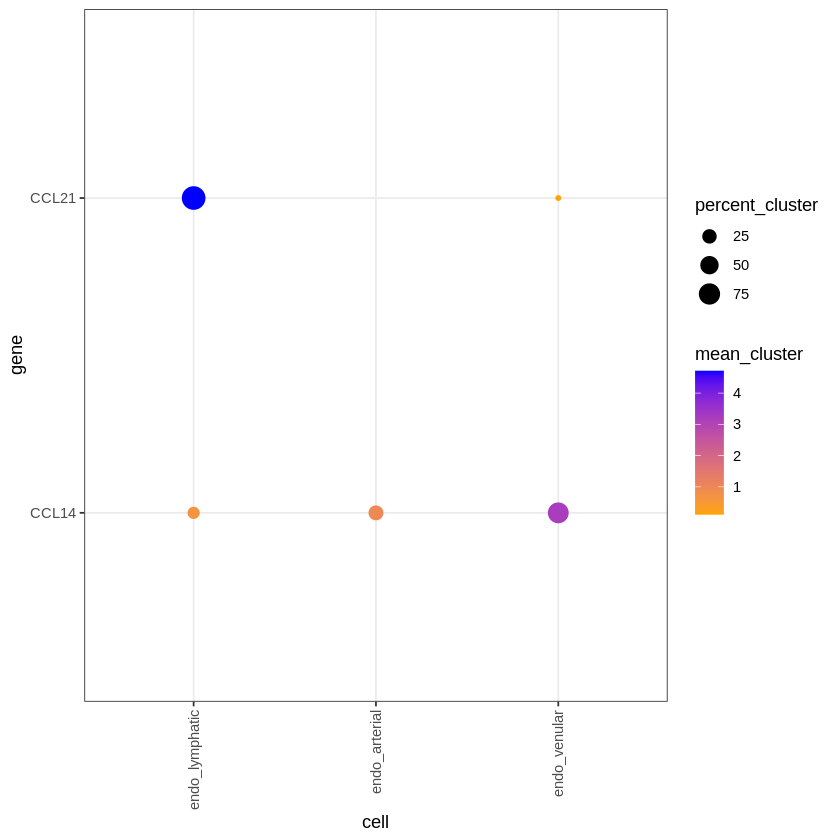

In [153]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# filter epi
df = df[ grep('endo', df$cell) ,]
df$cell = gsub('_scanpy', '', df$cell)
# ordre endo_venular; endo_arterial; endo_lymphatic
df$cell = factor(df$cell, levels = rev(c('endo_venular', 'endo_arterial', 'endo_lymphatic') ))
ggplot(df,  aes(y = gene,
                    x = cell,
                    color = mean_cluster,
                    size = percent_cluster), ) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

ggsave(filename = 'data/cellphoneDB/clusterDEGs_and_TFs/L_and_R_plots/Figure1F_dotplotReceptors.pdf', dpi = 300, width = 4, height = 3.8)